In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def create_cluster(linked, max_d):
    clusters = fcluster(linked, max_d, criterion='distance')
    return clusters

In [26]:
pcaData = pd.read_csv('./Data/PCAData.csv')
pcaData.drop(['Player','Team'],axis=1,inplace=True)
pcaData.describe().round(1)

,PC1,PC2,PC3,PC4,PC5
count,397.0,397.0,397.0,397.0,397.0
mean,-0.0,0.0,0.0,-0.0,0.0
std,5.4,4.7,2.8,2.5,2.1
min,-10.4,-8.2,-7.1,-6.3,-5.7
25%,-4.1,-3.3,-1.9,-1.6,-1.5
50%,-1.2,-1.0,-0.2,-0.0,-0.0
75%,3.3,2.3,1.9,1.6,1.3
max,16.9,16.5,8.1,8.9,9.6


In [27]:
# to standardise the principle components
scaler = StandardScaler()
pcaDataScaled = scaler.fit_transform(pcaData)

In [28]:
# check if components are standardised
pcaDataScaled = pd.DataFrame(pcaDataScaled, columns = ['PC1','PC2','PC3','PC4','PC5'])
pcaDataScaled.describe().round(1)

,PC1,PC2,PC3,PC4,PC5
count,397.0,397.0,397.0,397.0,397.0
mean,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0
min,-1.9,-1.8,-2.5,-2.5,-2.7
25%,-0.8,-0.7,-0.7,-0.6,-0.7
50%,-0.2,-0.2,-0.1,-0.0,-0.0
75%,0.6,0.5,0.7,0.6,0.6
max,3.1,3.5,2.9,3.6,4.5


In [29]:
# conducting hopkins test
hopkins(pcaDataScaled,pcaDataScaled.shape[0])

0.283332431485616

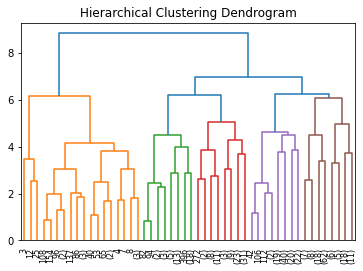

In [30]:
completeLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='complete')
completeLinknage = completeLinkage.fit(pcaDataScaled)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(completeLinkage, truncate_mode="level", p=5)
plt.show()

In [31]:
linkageMatrix = linkage(pcaDataScaled,'complete')
pcaDataScaled['completeCluster'] = create_cluster(linkageMatrix,6)
pcaDataScaled.groupby('completeCluster').mean()

,PC1,PC2,PC3,PC4,PC5
completeCluster,,,,,
1,2.222417,2.911025,-0.728139,2.809137,3.124340
2,1.733124,1.479560,0.201102,0.650145,0.648928
3,1.517478,-0.548024,0.958948,-0.413891,-0.594196
4,-0.345014,0.259148,-0.213425,0.438470,-0.901977
5,-0.042334,-0.364315,-0.912777,0.009287,0.222753
6,-0.440560,-0.674604,0.561060,-0.099966,0.700940
7,-0.828251,1.605224,0.450065,-0.848555,-0.192077


In [32]:
pcaDataScaled['completeCluster'].value_counts()

5    106
6     95
4     88
3     44
7     40
2     21
1      3
Name: completeCluster, dtype: int64

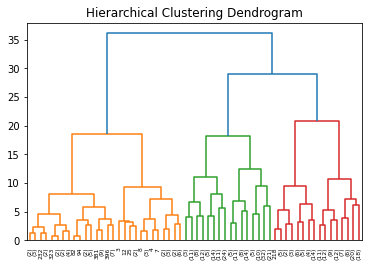

In [33]:
wardLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')
wardLinkage = wardLinkage.fit(pcaDataScaled)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(wardLinkage, truncate_mode="level", p=5)
plt.show()

In [34]:
linkageMatrix = linkage(pcaDataScaled,'ward')
pcaDataScaled['wardCluster'] = create_cluster(linkageMatrix,11)
pcaDataScaled.groupby('wardCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster
wardCluster,,,,,,
1,1.517478,-0.548024,0.958948,-0.413891,-0.594196,3.000
2,1.794286,1.658494,0.084947,0.920019,0.958354,1.875
3,-0.380791,-0.043142,-0.391181,1.389066,-1.183752,4.000
4,-0.322488,0.449479,-0.101505,-0.160053,-0.724563,4.000
5,0.362130,-0.121639,-1.100310,-0.976849,-0.054924,5.000
6,-0.268358,-0.499928,-0.807978,0.560363,0.377925,5.000
7,-0.828251,1.605224,0.450065,-0.848555,-0.192077,7.000
8,-0.440560,-0.674604,0.561060,-0.099966,0.700940,6.000


In [35]:
pcaDataScaled['wardCluster'].value_counts()

8    95
6    68
4    54
1    44
7    40
5    38
3    34
2    24
Name: wardCluster, dtype: int64

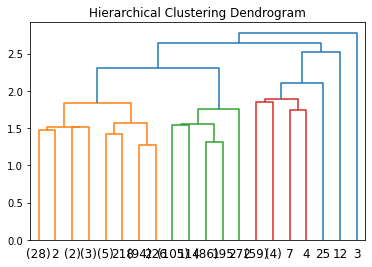

In [36]:
singleLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='single')
singleLinkage = singleLinkage.fit(pcaDataScaled)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(singleLinkage, truncate_mode="level", p=5)
plt.show()

In [37]:
linkageMatrix = linkage(pcaDataScaled,'single')
pcaDataScaled['singleCluster'] = create_cluster(linkageMatrix,11)
pcaDataScaled.groupby('singleCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster,wardCluster
singleCluster,,,,,,,
1,-1.929607e-17,4.524788e-16,-6.264231e-17,-3.742109e-17,5.005791e-17,4.808564,5.15869


In [38]:
pcaDataScaled['singleCluster'].value_counts()

1    397
Name: singleCluster, dtype: int64

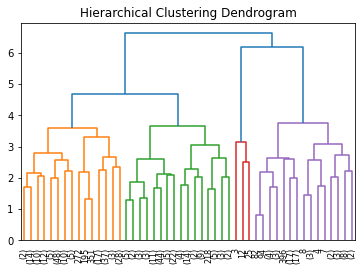

In [39]:
avgLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='average')
avgLinkage = avgLinkage.fit(pcaDataScaled)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(avgLinkage, truncate_mode="level", p=5)
plt.show()

In [40]:
linkageMatrix = linkage(pcaDataScaled,'average')
pcaDataScaled['averageCluster'] = create_cluster(linkageMatrix,4)
pcaDataScaled.groupby('averageCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster,wardCluster,singleCluster
averageCluster,,,,,,,,
1,-0.179632,-0.081507,-0.595545,0.203968,-0.287434,4.546392,4.721649,1.0
2,-0.555431,0.000900,0.528173,-0.321770,0.436343,6.296296,7.703704,1.0
3,2.222417,2.911025,-0.728139,2.809137,3.124340,1.000000,2.000000,1.0
4,1.587148,0.107042,0.714105,-0.070126,-0.192571,2.676923,1.323077,1.0


In [41]:
pcaDataScaled['averageCluster'].value_counts()

1    194
2    135
4     65
3      3
Name: averageCluster, dtype: int64

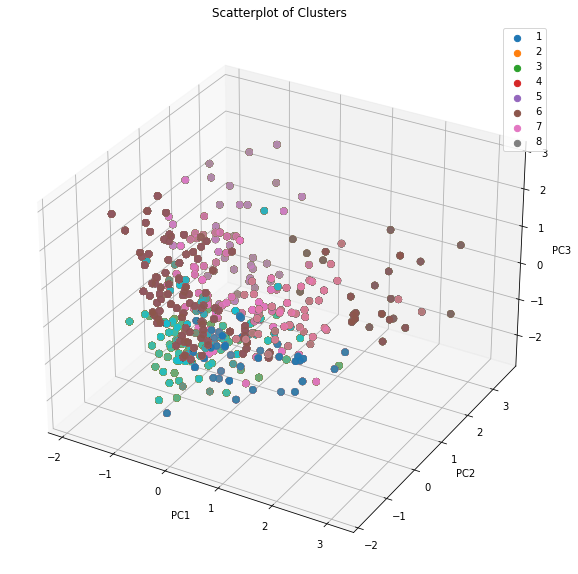

In [42]:

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for i in pcaDataScaled['wardCluster']:
    x = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC1'])
    y = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC2'])
    z = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC3'])
    ax.scatter(x, y, z, marker = 'o', s = 40)
plt.title('Scatterplot of Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([1,2,3,4,5,6,7,8])
plt.show()

In [43]:
fig2 = px.scatter_3d(pcaDataScaled, x='PC1', y='PC2', z='PC3', color='wardCluster')
fig2

In [44]:
pcaDataFull = pd.read_csv('./Data/PCAData.csv')
pcaDataScaled['PLAYER'] = pcaDataFull['Player'].values
pcaDataScaled['TEAM'] = pcaDataFull['Team'].values
pcaDataScaled = pcaDataScaled[['PLAYER','TEAM','wardCluster','PC1','PC2','PC3','PC4','PC5']]
pcaDataScaled.rename({'wardCluster':'CLUSTER'},axis=1,inplace=True)
pcaDataScaled.to_csv('Data/clusteredData.csv', index = False)